# Project : Coach Market

## Import Packages

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from contextily import add_basemap
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

## Functions

In [2]:
def nodes_color(graph):
    centrality=nx.eigenvector_centrality(graph, weight='weight')
    red_nodes=[i[0] for i in centrality.items() if i[1] >= 0.3]
    orange_nodes=[i[0] for i in centrality.items() if i[1] < 0.3 and i[1] >= 0.2 ]
    yellow_nodes=[i[0] for i in centrality.items() if i[1] < 0.2 and i[1] >= 0.1 ]
    color_map=[]
    for node in graph.nodes():
        if node in red_nodes:
            color_map.append('red')
        elif node in orange_nodes:
            color_map.append('orange')
        elif node in yellow_nodes:
            color_map.append('yellow')
        else:
            color_map.append('blue')
    return color_map

## Issue

The Macron law of August 6, 2015 authorizes coaches to operate between cities in different regions.<br>
Before this law, only trains (public monopoly) could make these journeys.<br>
This study seeks to study the current state of the market 6 years later:
<ul>
<li>Who are the main operators?</li>
<li>The structure of the networks and their sizes?</li>
<li>The type of competition between the actors?</li>
</ul>

## Import Data

The data use is from French Transport Regulatory Authority. <br>
Each connection between two cities is notified according to the number of trips and the operating company per trimester.<br>
<br>
source : https://www.autorite-transports.fr/observatoire-des-transports/jeux-de-donnees-en-open-data/


In [3]:
trimester=pd.read_excel('Donnees_trimestrielles_SLO_interurbains_autocar.xlsx', 'Tab3-Données liaisons', skiprows = 2)

In [4]:
trimester.head(5)

Année  Trimestre      Liaison Unité urbaine A Unité urbaine B  \
0   2015          3  00553_00753           00553           00753   
1   2015          3  00553_00760           00553           00760   
2   2015          3  00553_11501           00553           11501   
3   2015          3  00553_34502           00553           34502   
4   2015          3  00553_34701           00553           34701   

   Nombre d'opérateurs  Nombre de trajets sur le trimestre  Opérateur  \
0                    1                                 216  Eurolines   
1                    1                                 216  Eurolines   
2                    1                                 216  Eurolines   
3                    1                                 216  Eurolines   
4                    1                                 216  Eurolines   

   Nombre de trajets desservis par l'opérateur  
0                                          216  
1                                          216  
2                                          216  
3                                          216  
4                                          216

# Part I : evolution by year

## the evolution of market share between companies

#### exclusion of regional companies

In [5]:
flix_ouibus=['FlixBus','BlaBlaCar','Ouibus']
blabla_bus=['BlaBlaCar','Ouibus']

#### small companies are grouped together

In [6]:
trimester['Opérateur']=np.where(trimester['Opérateur'].isin(flix_ouibus), trimester['Opérateur'], 'autres')

In [7]:
trimester['Opérateur']=np.where(trimester['Opérateur'].isin(blabla_bus), 'BlaBlaCar (SNCF before 2019)', trimester['Opérateur'])

#### grouped by year

In [8]:
trimester_ope=trimester.groupby(['Année', 'Opérateur'], as_index=False).sum(["Nombre de trajets desservis par l'opérateur"])

In [9]:
trimester_ope.head(3)

Année                     Opérateur  Trimestre  Nombre d'opérateurs  \
0   2015  BlaBlaCar (SNCF before 2019)        300                  229   
1   2015                       FlixBus        911                  424   
2   2015                        autres       3195                 1420   

   Nombre de trajets sur le trimestre  \
0                              107705   
1                              145279   
2                              462194   

   Nombre de trajets desservis par l'opérateur  
0                                        22615  
1                                        66738  
2                                       266941

In [10]:
fig = px.bar(trimester_ope, x="Année", y="Nombre de trajets desservis par l'opérateur",
             color='Opérateur',
             labels={"Nombre de trajets desservis par l'opérateur": "in million",
                                               "Année": "year",
                    "Opérateur":"compagny"},
             height=400, title=0.14)

fig=fig.update_layout(title="Number of trips by compagny and by year",title_x=0.40)

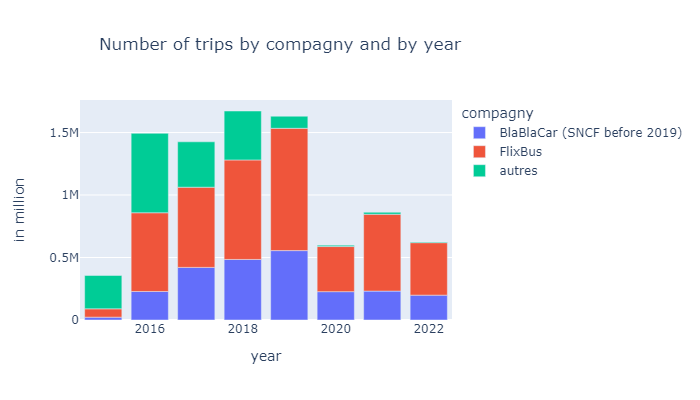

In [11]:
fig.show(renderer="png")

We can observe that since 2019, two brands control the market: Flixbus and BlaBlacar. <b> Are these two companies real competitors or do they work together? </b>

# Part II : Network analysis, an oligopoly situation between flixbus and blablacar

In [12]:
##referentiel geo des unites urbaines

In [13]:
uu=gpd.read_file('uu2020_2022.shp')

In [14]:
##nombre de liaisons

In [15]:
links=pd.read_excel('Donnees_trimestrielles_SLO_interurbains_autocar.xlsx', 'Tab3-Données liaisons', skiprows = 2)

In [16]:
links=links[links['Année']==2022].copy()

In [17]:
## select only uu with car connections

In [18]:
uu_A=links['Unité urbaine A'].tolist()

In [19]:
uu_B=links['Unité urbaine B'].tolist()

In [20]:
uu=uu[uu['uu2020'].isin(uu_A)|uu['uu2020'].isin(uu_B)].copy()
links=links[links['Unité urbaine A'].isin(uu['uu2020'].tolist())&links['Unité urbaine B'].isin(uu['uu2020'].tolist())].copy()

In [21]:
uu.head()

uu2020                                  libuu2020  \
5    00454                                   Honfleur   
13   10601                                     Troyes   
15   00653  Genève (SUI)-Annemasse (partie française)   
117  80601                                     Amiens   
119  38502                                     Voiron   

                                          tuu2017  \
5      Unité urbaine de 20 000 à 49 999 habitants   
13   Unité urbaine de 100 000 à 199 999 habitants   
15   Unité urbaine de 100 000 à 199 999 habitants   
117  Unité urbaine de 100 000 à 199 999 habitants   
119    Unité urbaine de 50 000 à 99 999 habitants   

                                         tduu2017  \
5      Unité urbaine de 20 000 à 24 999 habitants   
13   Unité urbaine de 100 000 à 149 999 habitants   
15   Unité urbaine de 150 000 à 199 999 habitants   
117  Unité urbaine de 150 000 à 199 999 habitants   
119    Unité urbaine de 50 000 à 69 999 habitants   

                                   type  nb_com  \
5    Agglomération inter-départementale      12   
13   Agglomération intra-départementale      18   
15         Agglomération internationale      35   
117  Agglomération intra-départementale      11   
119  Agglomération intra-départementale      15   

                                              geometry  
5    POLYGON ((0.29815 49.31441, 0.30705 49.31880, ...  
13   POLYGON ((4.09099 48.23526, 4.09774 48.24769, ...  
15   MULTIPOLYGON (((6.29009 46.11720, 6.30244 46.1...  
117  POLYGON ((2.37067 49.86586, 2.39612 49.86001, ...  
119  POLYGON ((5.50236 45.31991, 5.50300 45.32638, ...

In [22]:
## centroid of uu

In [23]:
uu=uu.to_crs('EPSG:2154')

In [24]:
uu.geometry=uu.geometry.centroid

In [25]:
uu=uu.to_crs('EPSG:4326')

In [26]:
## exclusion connections outside of europe

In [27]:
links=links[links['Liaison'].str.contains('A|B|C|D|E|F|G')==False].copy()

In [28]:
links=links.groupby(['Année','Liaison', 'Unité urbaine A', 'Unité urbaine B','Opérateur'], as_index=False).sum()

In [29]:
##keep only regular lines
links=links[links["Nombre de trajets desservis par l'opérateur"]>100].copy()

In [30]:
##coordinates of centroid A
links['x_A']=links['Unité urbaine A'].map(uu.set_index('uu2020')['geometry'].x)
links['y_A']=links['Unité urbaine A'].map(uu.set_index('uu2020')['geometry'].y)

##coordinates of centroid B
links['x_B']=links['Unité urbaine B'].map(uu.set_index('uu2020')['geometry'].x)
links['y_B']=links['Unité urbaine B'].map(uu.set_index('uu2020')['geometry'].y)

## Network BlaBlaCar

In [31]:
links_Bl=links[links['Opérateur']=='BlaBlaCar'].copy()

In [32]:
nodes_Bl=list(zip(links_Bl['Unité urbaine A'], links_Bl['x_A'], links_Bl['y_A']))

In [33]:
nodes_Bl=list(dict.fromkeys(nodes_Bl))

In [34]:
len(nodes_Bl)

57

In [35]:
nodes_Bl_bis=list(zip(links_Bl['Unité urbaine B'], links_Bl['x_B'], links_Bl['y_B']))

In [36]:
nodes_Bl_bis=list(set(nodes_Bl_bis) - set(nodes_Bl))

In [37]:
len(nodes_Bl_bis)

21

In [38]:
nodes_Bl=nodes_Bl+nodes_Bl_bis

In [39]:
int(nodes_Bl[0][0])

465

### creation of network BlaBlaCar

In [40]:
##nodes

In [41]:
G=nx.Graph()

In [42]:
for i in range(0, len(nodes_Bl)):
    ##print(nodes_Bl[i][0])
    G.add_node(node_for_adding=int(nodes_Bl[i][0]), pos=(nodes_Bl[i][1],nodes_Bl[i][2]))

In [43]:
pos=nx.get_node_attributes(G,'pos')

In [44]:
## edges

In [45]:
edges_Bl=list(zip(links_Bl['Unité urbaine A'], links_Bl['Unité urbaine B'], links_Bl["Nombre de trajets desservis par l'opérateur"]))

In [46]:
for i in range(0, len(edges_Bl)):
    ##print(nodes_Bl[i][0])
    G.add_edge(int(edges_Bl[i][0]), int(edges_Bl[i][1]), weight=edges_Bl[i][2])

In [47]:
#plt.figure(3,figsize=(14,14)) 
#nx.draw(G,pos)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#plt.show()

In [48]:
##size of edges
edges = G.edges()
weights = [G[u][v]['weight']*0.0015 for u,v in edges]


In [49]:
##plt.figure(3,figsize=(14,14)) 
##nx.draw(G, pos, width=weights)

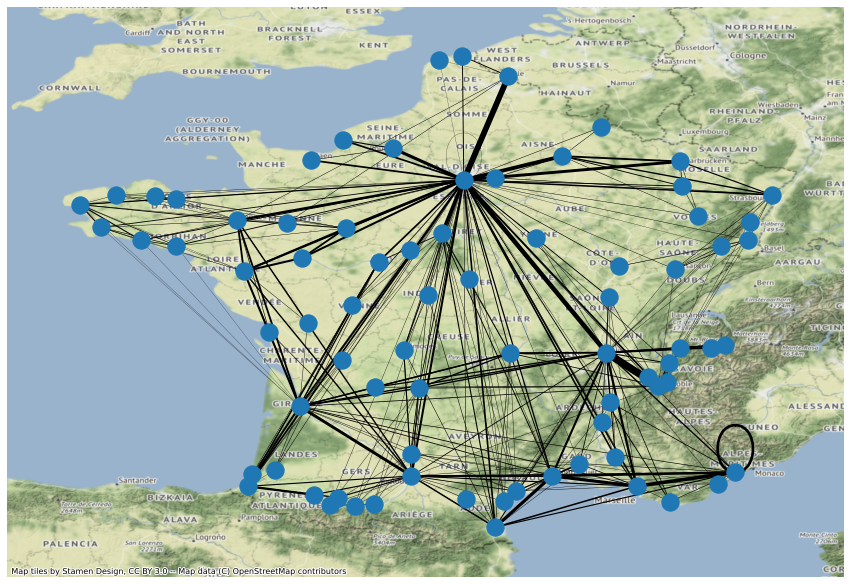

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.axis("off")
nx.draw(G, pos, width=weights, ax=ax)
add_basemap(ax, crs="EPSG:4326")
plt.show()

## Network Flixbus

In [51]:
links_Fl=links[links['Opérateur']=='FlixBus'].copy()

In [52]:
links_Fl

Année      Liaison Unité urbaine A Unité urbaine B Opérateur  Trimestre  \
0      2022  00360_00760           00360           00760   FlixBus          3   
5      2022  00460_00851           00460           00851   FlixBus          3   
6      2022  00460_10601           00460           10601   FlixBus          3   
7      2022  00460_51701           00460           51701   FlixBus          3   
8      2022  00460_54701           00460           54701   FlixBus          3   
...     ...          ...             ...             ...       ...        ...   
1283   2022  79501_86401           79501           86401   FlixBus          3   
1284   2022  79501_86601           79501           86601   FlixBus          3   
1285   2022  79501_91401           79501           91401   FlixBus          3   
1287   2022  82501_87601           82501           87601   FlixBus          3   
1290   2022  86601_91401           86601           91401   FlixBus          3   

      Nombre d'opérateurs  Nombre de trajets sur le trimestre  \
0                       2                                 296   
5                       2                                 375   
6                       2                                 206   
7                       2                                 376   
8                       2                                 345   
...                   ...                                 ...   
1283                    2                                 246   
1284                    2                                 452   
1285                    2                                 174   
1287                    4                                 857   
1290                    2                                 174   

      Nombre de trajets desservis par l'opérateur       x_A        y_A  \
0                                             296  5.802617  46.118973   
5                                             375  4.969136  48.636745   
6                                             206  4.969136  48.636745   
7                                             376  4.969136  48.636745   
8                                             345  4.969136  48.636745   
...                                           ...       ...        ...   
1283                                          246 -0.448914  46.317748   
1284                                          452 -0.448914  46.317748   
1285                                          174 -0.448914  46.317748   
1287                                          595  1.367295  44.007757   
1290                                          174  0.339136  46.628340   

           x_B        y_B  
0     4.819440  45.787247  
5     2.305564  48.829930  
6     4.078013  48.303687  
7     4.039654  49.251604  
8     6.151435  48.723720  
...        ...        ...  
1283  0.532537  46.814370  
1284  0.339136  46.628340  
1285  2.163453  48.432532  
1287  1.247217  45.842551  
1290  2.163453  48.432532  

[723 rows x 13 columns]

In [53]:
nodes_Fl=list(zip(links_Fl['Unité urbaine A'], links_Fl['x_A'], links_Fl['y_A']))

In [54]:
nodes_Fl=list(dict.fromkeys(nodes_Fl))

In [55]:
len(nodes_Fl)

92

In [56]:
nodes_Fl_bis=list(zip(links_Fl['Unité urbaine B'], links_Fl['x_B'], links_Fl['y_B']))

In [57]:
nodes_Fl_bis=list(set(nodes_Fl_bis) - set(nodes_Fl))

In [58]:
len(nodes_Fl_bis)

22

In [59]:
nodes_Fl=nodes_Fl+nodes_Fl_bis

In [60]:
len(nodes_Fl)

114

### creation of network

In [61]:
G2=nx.Graph()

In [62]:
for i in range(0, len(nodes_Fl)):
    ##print(nodes_Bl[i][0])
    G2.add_node(node_for_adding=int(nodes_Fl[i][0]), pos=(nodes_Fl[i][1],nodes_Fl[i][2]))

In [63]:
pos2=nx.get_node_attributes(G2,'pos')

In [64]:
edges_Fl=list(zip(links_Fl['Unité urbaine A'], links_Fl['Unité urbaine B'], links_Fl["Nombre de trajets desservis par l'opérateur"]))

In [65]:
for i in range(0, len(edges_Fl)):
    ##print(nodes_Bl[i][0])
    G2.add_edge(int(edges_Fl[i][0]), int(edges_Fl[i][1]), weight=edges_Fl[i][2])

In [66]:
##size of edges
edges = G2.edges()
weights2 = [G2[u][v]['weight']*0.0015 for u,v in edges]

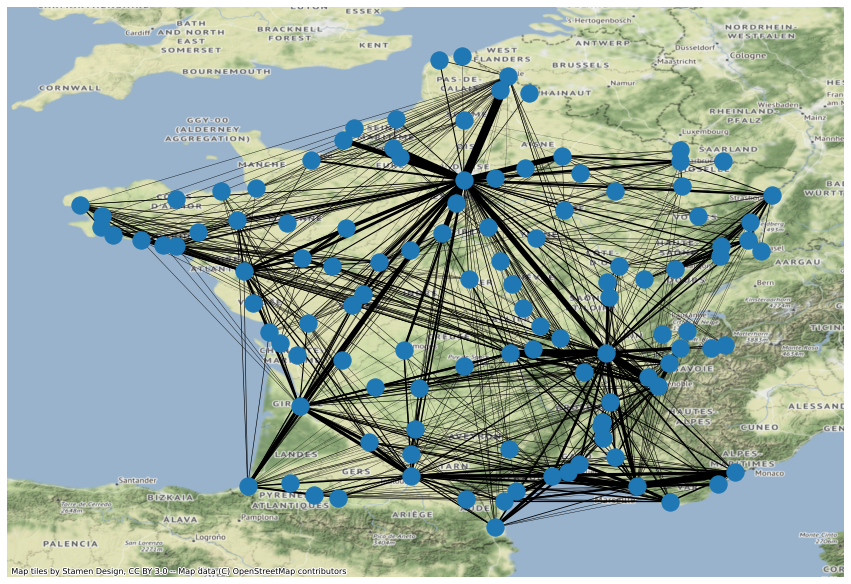

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.axis("off")
nx.draw(G2, pos2, width=weights2, ax=ax)
add_basemap(ax, crs="EPSG:4326")
plt.show()

## Comparing networks

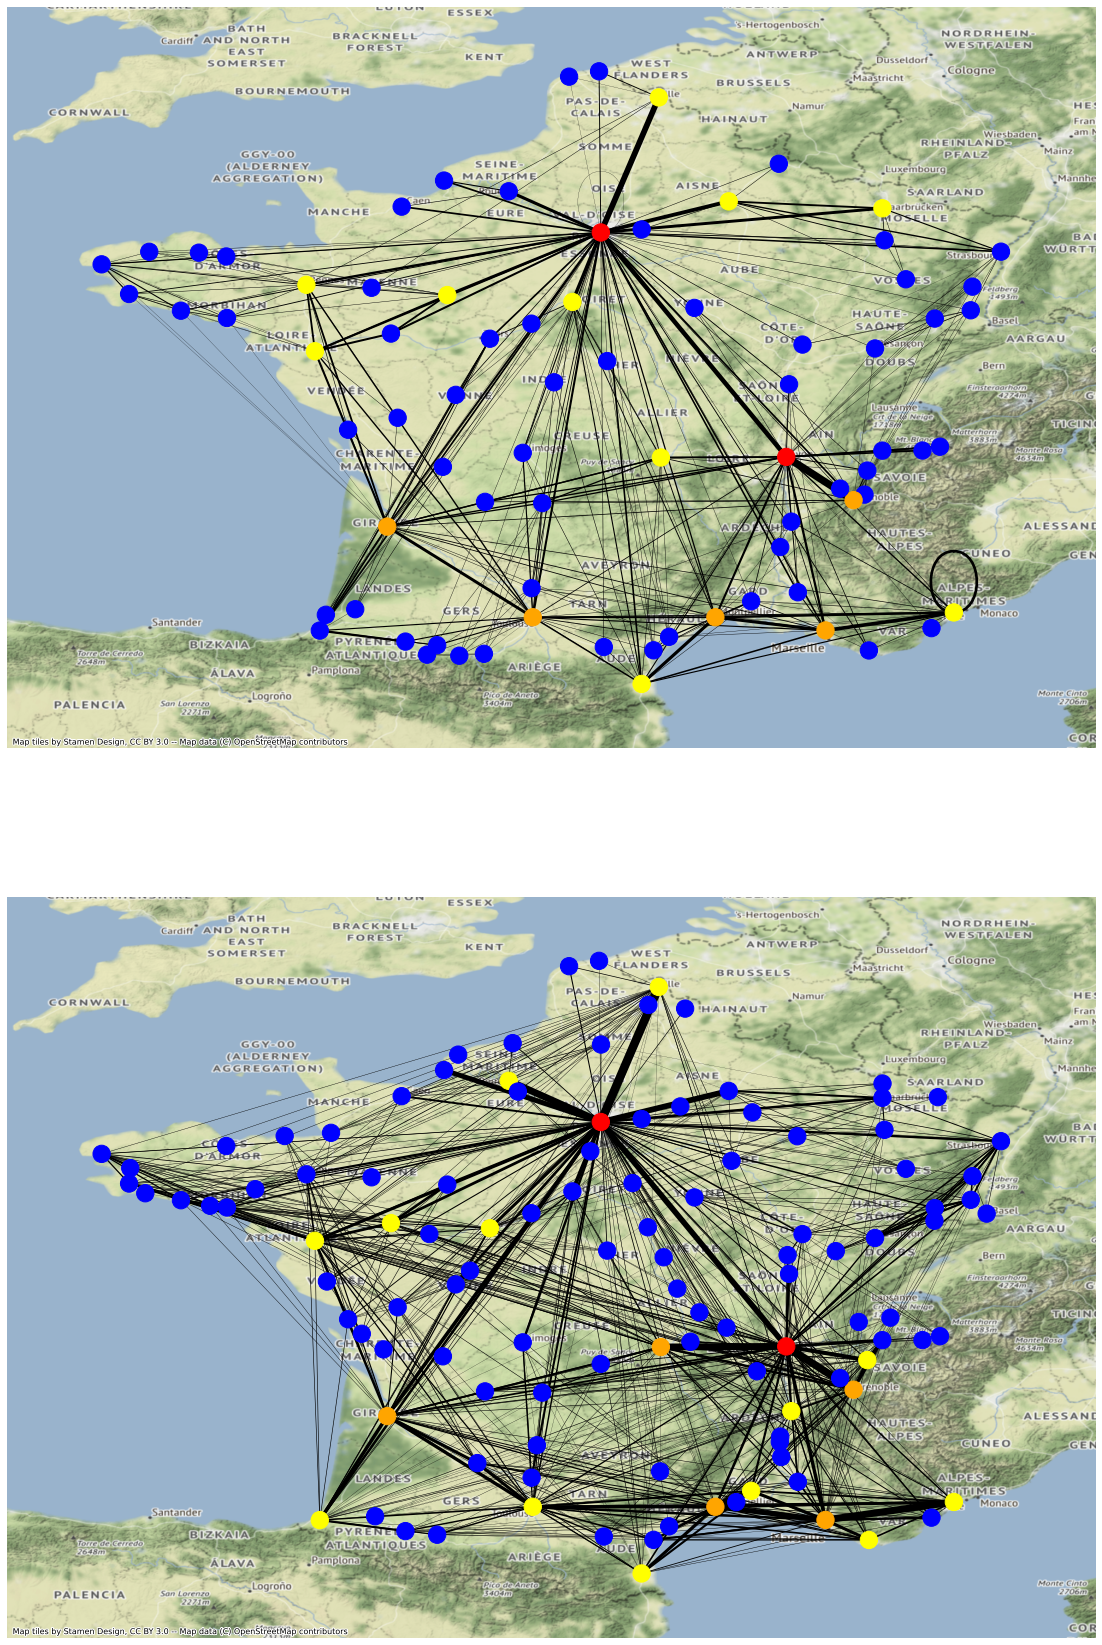

In [68]:
###definition du cadre
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 30))
##G1
color_map=nodes_color(G)
nx.draw(G, pos, width=weights, ax=ax1, node_color=color_map);
add_basemap(ax1, crs="EPSG:4326")
###G2
color_map=nodes_color(G2)
nx.draw(G2, pos2, width=weights2, ax=ax2, node_color=color_map);
add_basemap(ax2, crs="EPSG:4326")
plt.show()

We can see that the two networks are very similar and that they are structured in a similar way (except that flixbus is more developed).<br>
We can see that BlaBlacar is trying to establish itself more than its competitor in certain regions such as the Pyrenees or Burgundy where it serves more medium-sized cities.<br>
In a more general way, we note the strong use of this mode of transport in the south-east of France. 
It compensates for the absence of high-speed trains between medium-sized cities.